In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('./src')

from chatgpt_util_imports import generate_dataset
from data_loader import PatchDataset
from models import VAE, AE
from train import load_checkpoint, print_loss_metrics, save_checkpoint, train_one_epoch, validate
from util import get_date_and_time

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

In [2]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [3]:
# Load +31k patches as compiled by `bwhitman` for `learnfm`.
fpath = 'data/compact.bin'

df = generate_dataset(fpath)
df = pd.DataFrame(df)

print(f"Num patches: {len(df)}")
print(f"Num features: {len(df.keys())}")

# df.hist(figsize=(50, 50))
# plt.show()

Num patches: 31380
Num features: 146


In [4]:
p_train = 0.8
batch_size = 128

dataset = PatchDataset(df)

n_train = int(p_train * len(dataset))
n_val = len(dataset) - n_train

train_dataset, val_dataset = random_split(dataset, [n_train, n_val])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [5]:
dimensions = [128, 64, 32]
model_type = 'ae'

n_features = len(dataset._parameter_names)

if model_type == 'ae':
    model = AE(n_features, *dimensions)
elif model_type == 'vae':
    model = VAE(n_features, *dimensions)

model = model.to(device)

Epoch 0
Trn: 0.00579839	Val: 0.00484336



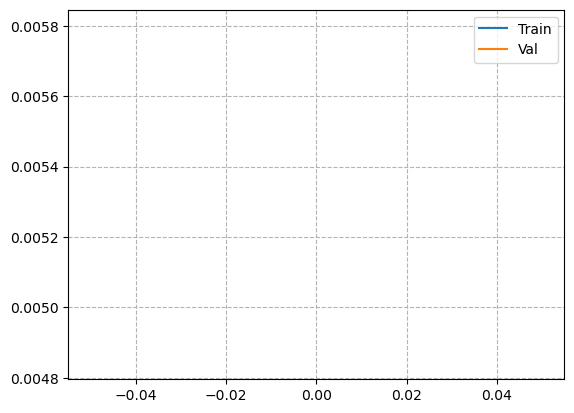

Saved checkpoint at: checkpoints/chkpnt_20231018_062707_epoch0.pt
Epoch 1
Trn: 0.00429350	Val: 0.00414492

Epoch 2
Trn: 0.00381595	Val: 0.00384026

Epoch 3
Trn: 0.00356072	Val: 0.00360939

Epoch 4
Trn: 0.00340022	Val: 0.00349139

Epoch 5
Trn: 0.00328960	Val: 0.00339126

Epoch 6
Trn: 0.00319355	Val: 0.00329406

Epoch 7
Trn: 0.00310471	Val: 0.00322212

Epoch 8
Trn: 0.00302223	Val: 0.00313481

Epoch 9
Trn: 0.00295793	Val: 0.00307052

Epoch 10
Trn: 0.00290504	Val: 0.00302551

Saved checkpoint at: checkpoints/chkpnt_20231018_062721_epoch10.pt
Epoch 11
Trn: 0.00285909	Val: 0.00299910

Epoch 12
Trn: 0.00282230	Val: 0.00296159

Epoch 13
Trn: 0.00278357	Val: 0.00291895

Epoch 14
Trn: 0.00275493	Val: 0.00289757



In [6]:
# Training.
n_epochs = 500
lr = 1e-3

checkpoint_dir = 'checkpoints/'
save_interval_epochs = 10
plot_interval_epochs = 25

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)

best_loss = np.inf
train_loss = []
val_loss = []
for i in range(n_epochs):
    epoch_train_loss = train_one_epoch(model, train_loader, optimizer, device, model_type)
    epoch_val_loss = validate(model, val_loader, device, model_type)
    scheduler.step(epoch_val_loss)

    train_loss.append(epoch_train_loss)
    val_loss.append(epoch_val_loss)

    print(f"Epoch {i}")
    print_loss_metrics(epoch_train_loss, epoch_val_loss)

    if i % plot_interval_epochs == 0:
        plt.plot(train_loss, label="Train")
        plt.plot(val_loss, label="Val")
        plt.grid(True, which="both", ls="--", c='0.7')
        plt.legend()
        plt.show()


    if i % save_interval_epochs != 0:
        continue

    if epoch_val_loss < best_loss:
        fname = f"chkpnt_{get_date_and_time()}_epoch{i}.pt"
        fpath = os.path.join(checkpoint_dir, fname)

        save_checkpoint(model, optimizer, fpath)

        print("=" * 80)
        print(f"Saved checkpoint at: {fpath}")
        print("=" * 80)

        best_loss = epoch_val_loss

In [ ]:
fpath = 'checkpoints/chkpnt_20231018_061656_epoch440.pt'
load_checkpoint(fpath, model, optimizer)
model.eval()

restore = dataset.get_restorer()

# Sample first 16 patches and their reconstructions.
patches = []
with torch.no_grad():
    for i, x in enumerate(dataset):
        x = x.to(device)

        if model_type == 'vae':
            y, mu, log_var = model(x)
        elif model_type == 'ae':
            y, z = model(x)

        x = x.to('cpu')
        y = y.to('cpu')

        x = restore(x)
        y = restore(y)

        x['VOICE NAME'] = f"x{i}"
        y['VOICE NAME'] = f"y{i}"

        patches.append(x)
        patches.append(y)

        if i >= 15:
            break

In [ ]:
from chatgpt_util_imports import make_cartridge

fpath = "data/test.syx"

cartridge_data = make_cartridge(patches)
with open(fpath, 'wb') as file:
    file.write(cartridge_data)